## Imports


In [14]:
import pandas as pd
import numpy as np

## Loading Dataset


In [15]:
# i want to put a json object in a pandas dataframe
df_1 = pd.read_json("annotated_jsons/AO_Output.json")
df_2 = pd.read_json("annotated_jsons/FA Output.json")
df_3 = pd.read_json("annotated_jsons/video_4_annotated.json")
df_4 = pd.read_json("annotated_jsons/integrated_data.json")
df_5 = pd.read_json("annotated_jsons/nadines_video_annotated.json")
df_6 = pd.read_json("annotated_jsons/video_1_annotated.json")

In [16]:
# add an index column to each dataframe
df_1["index"] = 1
df_2["index"] = 2
df_3["index"] = 3
df_4["index"] = 4
df_5["index"] = 5
df_6["index"] = 6

In [17]:
dfs = [df_1, df_2, df_3, df_4, df_5, df_6]
for idx, df in enumerate(dfs, 1):
    print(f"df_{idx} event value counts:")
    print(df["event"].value_counts())
    print("-" * 40)

df_1 event value counts:
event
backhand    112
forehand     68
Name: count, dtype: int64
----------------------------------------
df_2 event value counts:
event
backhand    113
forehand     61
Name: count, dtype: int64
----------------------------------------
df_3 event value counts:
event
backhand    50
forehand    26
Name: count, dtype: int64
----------------------------------------
df_4 event value counts:
event
backhand    12
forehand     5
Name: count, dtype: int64
----------------------------------------
df_5 event value counts:
event
backhand    17
forehand    14
Name: count, dtype: int64
----------------------------------------
df_6 event value counts:
event
backhand    49
forehand    29
Name: count, dtype: int64
----------------------------------------


In [18]:
train_df = pd.concat([df_5, df_2, df_1, df_4, df_6], ignore_index=True)
test_df = df_3.copy()

In [19]:
train_df.shape

(31499, 6)

In [20]:
train_df["event"].value_counts()

event
backhand    303
forehand    177
Name: count, dtype: int64

In [21]:
test_df.shape

(9988, 6)

In [22]:
test_df["event"].value_counts()

event
backhand    50
forehand    26
Name: count, dtype: int64

In [23]:
def expand_df(df):
    expanded_df = (
        df["keypoints"]
        .apply(
            lambda person: {f"x_{part}": person[part]["x"] for part in person}
            | {f"y_{part}": person[part]["y"] for part in person}
        )
        .apply(pd.Series)
    )

    # Merge back into original df if needed
    df_expanded = pd.concat([df, expanded_df], axis=1)

    # Optionally drop original nested column
    df_expanded.drop(columns=["keypoints"], inplace=True)
    return df_expanded


train_df_expanded = expand_df(train_df)
test_df_expanded = expand_df(test_df)

In [24]:
train_df_expanded.shape

(31499, 29)

In [25]:
def normalize_keypoints_df(df):
    """
    Normalize all keypoints in the dataframe using body-relative normalization
    REPLACES original x_, y_ columns with normalized values

    Args:
        df: DataFrame with columns: x_left_shoulder, y_left_shoulder, etc.

    Returns:
        df_normalized: DataFrame with normalized keypoint columns (same column names)
    """
    df_norm = df.copy()

    # Keypoint names
    keypoint_names = [
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle",
    ]

    # Normalize frame by frame
    for idx, row in df.iterrows():
        # Calculate hip center
        hip_center_x = (row["x_left_hip"] + row["x_right_hip"]) / 2
        hip_center_y = (row["y_left_hip"] + row["y_right_hip"]) / 2

        # Calculate shoulder center
        shoulder_center_x = (row["x_left_shoulder"] + row["x_right_shoulder"]) / 2
        shoulder_center_y = (row["y_left_shoulder"] + row["y_right_shoulder"]) / 2

        # Calculate torso length
        torso_length = np.sqrt(
            (shoulder_center_x - hip_center_x) ** 2
            + (shoulder_center_y - hip_center_y) ** 2
        )

        if torso_length < 1e-6:
            torso_length = 1.0

        # REPLACE original columns with normalized values
        for name in keypoint_names:
            df_norm.at[idx, f"x_{name}"] = (
                row[f"x_{name}"] - hip_center_x
            ) / torso_length
            df_norm.at[idx, f"y_{name}"] = (
                row[f"y_{name}"] - hip_center_y
            ) / torso_length

    return df_norm


train_df_expanded = normalize_keypoints_df(train_df_expanded)
test_df_expanded = normalize_keypoints_df(test_df_expanded)

In [26]:
def add_sequence(df_expanded, frame_window=15):
    event_indices = df_expanded[df_expanded["event"].notnull()].index

    selected_indices = set()
    neither_count = 0
    MAX_NEITHER_SEGMENTS = 100

    # Step 1: Annotate labeled events and their 15-frame tails
    for idx in event_indices:
        label = df_expanded.at[idx, "event"]
        group_id = df_expanded.at[idx, "index"]
        selected_indices.add(idx)
        df_expanded.at[idx, "event"] = label

        # Add 7 frames BEFORE the annotated label
        for offset in range(0, int(frame_window / 2)):
            prev_idx = idx - offset
            if prev_idx < 0:
                break

            if (
                pd.notnull(df_expanded.at[prev_idx, "event"])
                or df_expanded.at[prev_idx, "index"] != group_id
            ):
                break

            selected_indices.add(prev_idx)
            df_expanded.at[prev_idx, "event"] = label

        # Add 7 frames AFTER the annotated label
        for offset in range(0, int(frame_window / 2)):
            next_idx = idx + offset
            if next_idx >= len(df_expanded):
                break

            if (
                pd.notnull(df_expanded.at[next_idx, "event"])
                or df_expanded.at[next_idx, "index"] != group_id
            ):
                break

            selected_indices.add(next_idx)
            df_expanded.at[next_idx, "event"] = label

    # Step 2: Annotate null event segments in frame_window-frame "neither" batches
    null_indices = df_expanded[df_expanded["event"].isnull()].index
    null_indices = sorted(null_indices)

    i = 0
    while i < len(null_indices):
        if neither_count >= MAX_NEITHER_SEGMENTS:
            break

        start_idx = null_indices[i]
        group_id = df_expanded.at[start_idx, "index"]

        # Collect consecutive nulls in same group
        segment = [start_idx]
        for j in range(i + 1, len(null_indices)):
            current_idx = null_indices[j]
            prev_idx = null_indices[j - 1]

            if (
                current_idx == prev_idx + 1
                and df_expanded.at[current_idx, "index"] == group_id
            ):
                segment.append(current_idx)
            else:
                break

        # Process in batches of frame_window
        for k in range(0, len(segment), frame_window):
            if neither_count >= MAX_NEITHER_SEGMENTS:
                break

            batch = segment[k : k + frame_window]
            if len(batch) == frame_window:
                for idx in batch:
                    selected_indices.add(idx)
                    df_expanded.at[idx, "event"] = "neither"
                neither_count += 1

        i += len(segment)

    # Step 3: Final filtering
    df_expanded = df_expanded.loc[sorted(selected_indices)].reset_index(drop=True)

    print(f"Number of 'neither' segments (frame_window-frame batches): {neither_count}")

    return df_expanded


train_df_expanded = add_sequence(train_df_expanded)
test_df_expanded = add_sequence(test_df_expanded)

Number of 'neither' segments (frame_window-frame batches): 100
Number of 'neither' segments (frame_window-frame batches): 100


In [27]:
train_df_expanded["event"].value_counts()

event
neither     1500
backhand     303
forehand     177
Name: count, dtype: int64

In [28]:
test_df_expanded["event"].value_counts()

event
neither     1500
backhand      50
forehand      26
Name: count, dtype: int64

## Better Approach (LSTM - 30 Frames per event)


In [29]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
# lstm_df = pd.read_csv(
#     "/home/g03-s2025/Desktop/SquashCoachingCopilot/cv-module/digitization/event-recognition/stroke-detection/implementation/annotated_jsons/combined_data.csv"
# )

In [ ]:
# # ----------------------------
# # Step 1: Normalize coordinates
# # ----------------------------
# coord_cols = [
#     col
#     for col in train_df_expanded.columns
#     if col.startswith("x") or col.startswith("y")
# ]
# scaler = MinMaxScaler()
# train_df_expanded[coord_cols] = scaler.fit_transform(train_df_expanded[coord_cols])

In [30]:
train_df_expanded.drop(columns=["player_id", "time", "index"], inplace=True)
test_df_expanded.drop(columns=["player_id", "time", "index"], inplace=True)

In [31]:
# Step 2: Label encoding
# ----------------------------
label_map = {"forehand": 0, "backhand": 1, "neither": 2}
train_df_expanded = train_df_expanded[
    train_df_expanded["event"].isin(label_map.keys())
].copy()
train_df_expanded["event"] = train_df_expanded["event"].map(label_map).astype(int)

In [ ]:
# # ----------------------------
# # Step 1: Normalize coordinates
# # ----------------------------
# coord_cols = [
#     col
#     for col in test_df_expanded.columns
#     if col.startswith("x") or col.startswith("y")
# ]
# scaler = MinMaxScaler()
# test_df_expanded[coord_cols] = scaler.fit_transform(test_df_expanded[coord_cols])

In [32]:
coord_cols = [
    col
    for col in test_df_expanded.columns
    if col.startswith("x") or col.startswith("y")
]

In [33]:
# Step 2: Label encoding
# ----------------------------
label_map = {"forehand": 0, "backhand": 1, "neither": 2}
test_df_expanded = test_df_expanded[
    test_df_expanded["event"].isin(label_map.keys())
].copy()
test_df_expanded["event"] = test_df_expanded["event"].map(label_map).astype(int)

In [34]:
# Data preparation with non-overlapping windows
X_train = []
y_train = []
window_size = 15

# Process the data in non-overlapping chunks of size 15
for i in range(0, len(train_df_expanded), window_size):
    # Check if we have a full window
    if i + window_size <= len(train_df_expanded):
        window = train_df_expanded.iloc[i : i + window_size]

        # Only use the window if all rows have the same event
        if window["event"].nunique() == 1:
            X_train.append(
                window[coord_cols].values
            )  # Shape: (15, 24) - 15 timesteps, 24 features
            # Store the single event for this window
            y_train.append(window["event"].iloc[0])

X_train = np.array(X_train)  # shape should be (num_non_overlapping_windows, 15, 24)
y_train = np.array(y_train)  # shape should be (num_non_overlapping_windows,)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Label distribution: {np.unique(y_train, return_counts=True)}")

X_train shape: (62, 15, 24)
y_train shape: (62,)
Label distribution: (array([1, 2]), array([ 1, 61]))


In [35]:
# Data preparation with non-overlapping windows
X_test = []
y_test = []
window_size = 15

# Process the data in non-overlapping chunks of size 16
for i in range(0, len(test_df_expanded), window_size):
    # Check if we have a full window
    if i + window_size <= len(test_df_expanded):
        window = test_df_expanded.iloc[i : i + window_size]

        # Only use the window if all rows have the same event
        if window["event"].nunique() == 1:
            X_test.append(
                window[coord_cols].values
            )  # Shape: (16, 24) - 16 timesteps, 24 features
            # Store the single event for this window
            y_test.append(window["event"].iloc[0])

X_test = np.array(X_test)  # shape should be (num_non_overlapping_windows, 16, 24)
y_test = np.array(y_test)  # shape should be (num_non_overlapping_windows,)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Label distribution: {np.unique(y_test, return_counts=True)}")

X_test shape: (89, 15, 24)
y_test shape: (89,)
Label distribution: (array([2]), array([89]))


In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

In [36]:
model = Sequential()
# Input shape: (16 timesteps, 24 features)
model.add(LSTM(16, input_shape=(window_size, len(coord_cols)), return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(3, activation="softmax"))  # 3 classes (0, 1, 2)

model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

/Users/youssef/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [37]:
# ----------------------------
# Step 6: Training
# ----------------------------
# Class weights
from sklearn.utils.class_weight import compute_class_weight

# Don't use SMOTE, use class weights instead
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)

class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")
# Example: {0: 0.5, 1: 5.0, 2: 5.0}  # penalizes misclassifying minority classes

# Early stopping
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Training the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=8,  # You can adjust this batch size for training
    callbacks=[early_stop],
    verbose=1,
    class_weight=class_weight_dict,
)

Class weights: {0: 31.0, 1: 0.5081967213114754}
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0631 - loss: 1.4391 - val_accuracy: 0.2921 - val_loss: 1.0665
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7073 - loss: 0.9585 - val_accuracy: 1.0000 - val_loss: 0.6884
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.6585 - val_accuracy: 1.0000 - val_loss: 0.4455
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9347 - loss: 0.4545 - val_accuracy: 1.0000 - val_loss: 0.2925
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9743 - loss: 0.2711 - val_accuracy: 1.0000 - val_loss: 0.1963
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9944 - loss: 0.1999 - val_accuracy: 1.0000 - val_loss: 0.1363
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9964 - loss: 0.1296 - val_accuracy: 1.0000 - val_loss: 0.0993
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9604 - loss:

In [38]:
# print classification report


# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(model.predict(X_test), axis=1)
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           2       1.00      1.00      1.00        89

    accuracy                           1.00        89
   macro avg       1.00      1.00      1.00        89
weighted avg       1.00      1.00      1.00        89



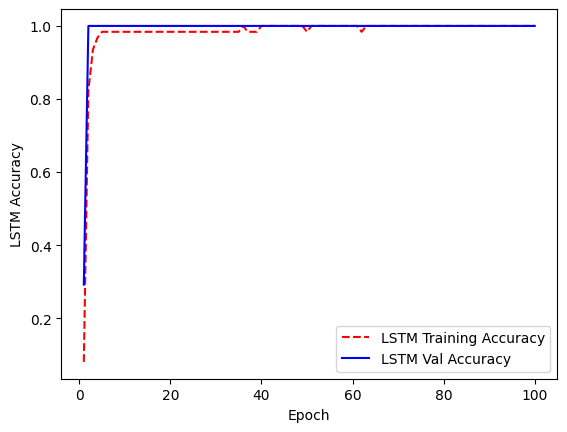

In [39]:
# Get training and validation accuracy histories
import matplotlib.pyplot as plt

training_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

EPOCHS = len(training_acc)

# Create count of the number of epochs
epoch_count = range(1, EPOCHS + 1)

# Visualize accuracy history
plt.figure()
plt.plot(epoch_count, training_acc, "r--")
plt.plot(epoch_count, val_acc, "b-")
plt.legend(["LSTM Training Accuracy", "LSTM Val Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("LSTM Accuracy")
plt.show()

In [ ]:
# train_df_expanded[coord_cols].values

In [ ]:
# X = train_df_expanded.drop(columns=["event"])
# y = train_df_expanded["event"]

# test_x = test_df_expanded.drop(columns=["event"])
# test_y = test_df_expanded["event"]

In [ ]:
# # import xgboost
# from xgboost import XGBClassifier

# xgb = XGBClassifier()
# xgb.fit(X, y)
# y_pred_xgb = xgb.predict(test_x)
# print(classification_report(test_y, y_pred_xgb))

In [ ]:
# comparison_df = pd.DataFrame(
#     {
#         "y_true": test_y,
#         "y_pred": y_pred_xgb,
#     }
# )

In [ ]:
# save lstm model
model.save("lstm_model.h5")